# Preparation

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import plot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import randint
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [2]:
# configuration
import warnings
warnings.filterwarnings('ignore')

# plot style
%matplotlib inline
sns.set_context('notebook')
sns.set_style('ticks')
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# read the data
iFood = pd.read_csv('ifood_marketing.csv')

In [4]:
# data splitting before analysis
# split the data into train, validation and test
target_y = iFood['MntWines']
features_X = iFood.loc[:, iFood.columns != 'MntWines']

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features_X, target_y, test_size=0.2, random_state=1)

# split the train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Primary Goal

Find a model that is accurate in predicting the money spent on Wine products in the last two years for a given customer


## Initial EDA on Training Dataset


In [5]:
# glimpse of the training set
X_train.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
502,8151,1990,Basic,Married,24279.0,0,0,2012-12-29,6,36,...,8,0,0,0,0,0,0,3,11,0
424,6932,1941,PhD,Married,93027.0,0,0,2013-04-13,77,42,...,2,0,0,1,0,0,0,3,11,0
1467,7521,1952,Graduation,Together,83844.0,0,0,2013-05-12,57,31,...,1,0,0,1,0,0,0,3,11,0
1070,10536,1971,PhD,Together,32892.0,1,0,2014-05-25,78,0,...,8,0,0,0,0,0,0,3,11,0
1065,4415,1961,Graduation,Married,16860.0,1,1,2012-09-12,19,4,...,7,0,0,0,0,0,0,3,11,0


In [6]:
# size of the training set
print(X_train.shape)

# data types of the training set
X_train.info()

(1433, 28)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1433 entries, 502 to 1866
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1433 non-null   int64  
 1   Year_Birth           1433 non-null   int64  
 2   Education            1433 non-null   object 
 3   Marital_Status       1433 non-null   object 
 4   Income               1418 non-null   float64
 5   Kidhome              1433 non-null   int64  
 6   Teenhome             1433 non-null   int64  
 7   Dt_Customer          1433 non-null   object 
 8   Recency              1433 non-null   int64  
 9   MntFruits            1433 non-null   int64  
 10  MntMeatProducts      1433 non-null   int64  
 11  MntFishProducts      1433 non-null   int64  
 12  MntSweetProducts     1433 non-null   int64  
 13  MntGoldProds         1433 non-null   int64  
 14  NumDealsPurchases    1433 non-null   int64  
 15  NumWebPurchases      1433

In [7]:
# checking missing data
X_train.isnull().sum()

# table of missing data of variables
missing = pd.DataFrame(X_train.isnull().sum())
missing.columns = ['Count of Missing Values']
missing

,Count of Missing Values
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,15
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntFruits,0


In [8]:
# examining the unique values of each column to see if there are any impossible values and degenerate features
constant_cols = [] # column name
invalid_values = {} # column name: invalid values
num_unique_values = {} # column name: number of unique values for each column

for col in X_train.columns:
    # print(col, ': ', np.sort(X_train[col].unique()))
    num_unique_values[col] = X_train[col].nunique()
    # if datatype is numeric, check if there are any impossible values (e.g. negative values in the context of this dataset where all the features should be positive)
    if X_train[col].dtype != 'object':
        for value in X_train[col].unique():
            if value < 0:
                invalid_values[col] = value
    # check for constant columns
    if len(X_train[col].unique()) == 1:
        constant_cols.append(col)

print('Constant columns: ', constant_cols)
print('Invalid values: ', invalid_values)

# present the number of unique values in a labelled table
unique_values = pd.DataFrame.from_dict(num_unique_values, orient='index', columns=['Number of unique values'])
unique_values

Constant columns:  ['Z_CostContact', 'Z_Revenue']
Invalid values:  {}


,Number of unique values
ID,1433
Year_Birth,57
Education,5
Marital_Status,8
Income,1312
Kidhome,3
Teenhome,3
Dt_Customer,599
Recency,100
MntFruits,146


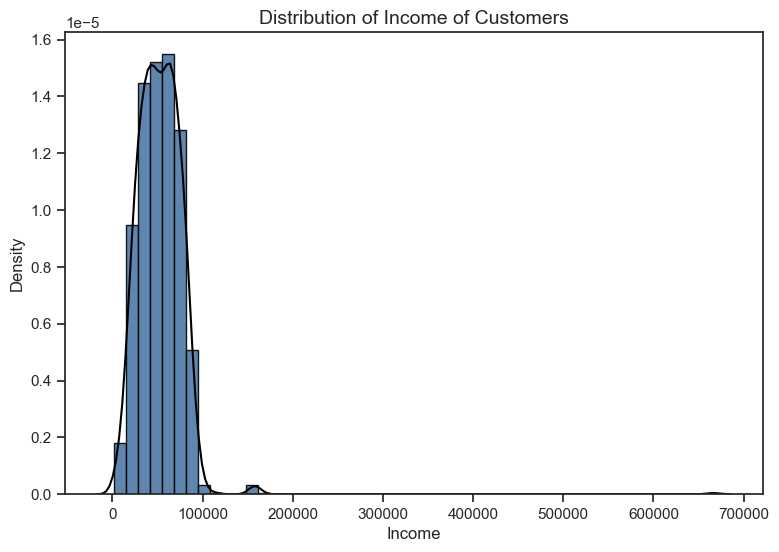

In [9]:
# distribution of income variable informing the choice of imputation
fig, ax= plt.subplots()
sns.distplot(X_train['Income'], ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': '#4E79A7'},
             kde_kws={'color': 'black', 'alpha': 0.7})
ax.set_title('Distribution of Income of Customers', fontsize=14)
plt.show()

Findings:

1. There are 1433 observations in the training data frame, with 28 variables. 
- From initial glimpse of the predictors, it is evident that we need to perform standardisations as predictors are measured in different units with varying scales. (E.g. `Income` is measured in dollars, while `NumWebVisitsMonth` is measured in number of visits)
- From examining the unique values in each predictors, there are constant columns found, namely `Z_CostContact` and `Z_Revenue`. These variables will be dropped as they do not provide any information to the model.

2. dtypes: float64(1), int64(24), object(3) indicates that: 
- Among the 28 variables, `Education`, `Marital_Status` and `Dt_Customer` are of object type, indicating the cateogrical nature of these variables, which requires further encoding. 
- However, `Dt_Customer` is a date variable, where derived features like the age of the customer when they joined the company may be useful in predicting the target variable. (`age_joined` = `Dt_Customer` - `Year_Birth`)
- The remaining 25 variables are numerical, with `Income` being the only float type variable, and the rest are integers.

3. There are 15 missing values in `Income` variable, which 15/1433 = 1.05% of the total observations in the training set. However, given the goal of maximising predictive accuracy, it is not recommended to drop these observations, as it may lead to a loss of information. Therefore an indicator variable `income_missing` will be created to indicate whether the value of `Income` is missing or not. Subsequently, the performance of the models with different imputation strategies will be evaluated.
Here are some of the imputation strategies that will be considered: 
- Impute the missing values with the mean of the variable (violates independence and not robust to outliers)
- Impute the missing values with the median of the variable
- Impute missing values based on the values of their k-nearest neighbours (computational exhaustive)

Reference: https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/#h-3-filling-the-missing-values-imputation 

4. From examining the explanatory variables, it is evident that some variables should not be used given the context

## Data Cleaning in Preparation for Modelling

In [10]:
# make a copy of the training, validation and test set for data cleaning
X_train_clean = X_train.copy()
X_val_clean = X_val.copy()
X_test_clean = X_test.copy()

In [11]:
# cleaning based on finding 2
# encode cateogrical varaibles into dummy variables
dummy_var_dict = {}
def dummy_var(df, cat_var):
    for i in range(0, df[cat_var].nunique()):
        cat_name = df[cat_var].unique()[i]
        # store the dummy variable and corresponding number of the categor in a dictionary
        dummy_var_dict[cat_name] = i+1
        df[cat_var].replace(cat_name, i+1, inplace=True)

# encode `education` and `marital_status` into dummy variables
dummy_var(X_train_clean, 'Education')
dummy_var(X_train_clean, 'Marital_Status')
dummy_var(X_val_clean, 'Education')
dummy_var(X_val_clean, 'Marital_Status')
dummy_var(X_test_clean, 'Education')
dummy_var(X_test_clean, 'Marital_Status')

# glimpse of the cleaned training set
X_train_clean.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
502,8151,1990,1,1,24279.0,0,0,2012-12-29,6,36,...,8,0,0,0,0,0,0,3,11,0
424,6932,1941,2,1,93027.0,0,0,2013-04-13,77,42,...,2,0,0,1,0,0,0,3,11,0
1467,7521,1952,3,2,83844.0,0,0,2013-05-12,57,31,...,1,0,0,1,0,0,0,3,11,0
1070,10536,1971,2,2,32892.0,1,0,2014-05-25,78,0,...,8,0,0,0,0,0,0,3,11,0
1065,4415,1961,3,1,16860.0,1,1,2012-09-12,19,4,...,7,0,0,0,0,0,0,3,11,0


In [12]:
# dictionary of dummy variables for later reference
dummy_var_dict

{'Basic': 5,
 'PhD': 2,
 'Graduation': 1,
 '2n Cycle': 4,
 'Master': 3,
 'Married': 4,
 'Together': 3,
 'Divorced': 2,
 'Single': 1,
 'Widow': 5,
 'Alone': 6,
 'YOLO': 6,
 'Absurd': 8}

In [13]:
# cleaning based on finding 2
# replace year_birth and dt_customer with age_joined
X_train_clean['age_joined'] = X_train_clean['Dt_Customer'].str.split('-').str[0].astype(int) - X_train_clean['Year_Birth']

# drop due to multicollinearity as age_joined directly depends on these two features
X_train_clean.drop(['Year_Birth', 'Dt_Customer'], axis=1, inplace=True) 

# apply the same transformations to the validation and test sets to ensure consistency
X_val_clean['age_joined'] = X_val_clean['Dt_Customer'].str.split('-').str[0].astype(int) - X_val_clean['Year_Birth']
X_val_clean.drop(['Year_Birth', 'Dt_Customer'], axis=1, inplace=True)

X_test_clean['age_joined'] = X_test_clean['Dt_Customer'].str.split('-').str[0].astype(int) - X_test_clean['Year_Birth']
X_test_clean.drop(['Year_Birth', 'Dt_Customer'], axis=1, inplace=True)

# glimpse of the cleaned training set
X_train_clean.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,age_joined
502,8151,1,1,24279.0,0,0,6,36,21,20,...,0,0,0,0,0,0,3,11,0,22
424,6932,2,1,93027.0,0,0,77,42,716,55,...,0,0,1,0,0,0,3,11,0,72
1467,7521,3,2,83844.0,0,0,57,31,345,75,...,0,0,1,0,0,0,3,11,0,61
1070,10536,2,2,32892.0,1,0,78,0,15,2,...,0,0,0,0,0,0,3,11,0,43
1065,4415,3,1,16860.0,1,1,19,4,4,3,...,0,0,0,0,0,0,3,11,0,51


In [14]:
# cleaning based on finding 1 and 4
# clean the obvious variable that should not be used given the context (ID) and the degenerate features (constant columns)
def drop_cols(df, cols):
    for i in range(0, len(cols)):
        df.drop(cols[i], axis=1, inplace=True)
    
cols_to_drop = ['ID'] + constant_cols
drop_cols(X_train_clean, cols_to_drop)
drop_cols(X_val_clean, cols_to_drop)
drop_cols(X_test_clean, cols_to_drop)

X_train_clean.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined
502,1,1,24279.0,0,0,6,36,21,20,62,...,3,8,0,0,0,0,0,0,0,22
424,2,1,93027.0,0,0,77,42,716,55,0,...,5,2,0,0,1,0,0,0,0,72
1467,3,2,83844.0,0,0,57,31,345,75,31,...,11,1,0,0,1,0,0,0,0,61
1070,2,2,32892.0,1,0,78,0,15,2,1,...,3,8,0,0,0,0,0,0,0,43
1065,3,1,16860.0,1,1,19,4,4,3,3,...,3,7,0,0,0,0,0,0,0,51


In [15]:
# cleaning based on finding 3
# insert a new column to indicate missingness of income data, 1 for missing, 0 for not missing
X_train_clean['income_missing'] = np.where(X_train_clean['Income'].isnull(), 1, 0)

# check the count of missing data
print(X_train_clean['income_missing'].value_counts())

# apply the same transformations to the validation and test sets to ensure consistency
X_val_clean['income_missing'] = np.where(X_val_clean['Income'].isnull(), 1, 0)
X_test_clean['income_missing'] = np.where(X_test_clean['Income'].isnull(), 1, 0)

0    1418
1      15
Name: income_missing, dtype: int64


In [16]:
# cleaning based on finding 3
# impute the missing values with median
X_train_clean['Income'] = X_train_clean['Income'].fillna(X_train_clean['Income'].median())
# double check if there are any missing values after imputation
print(X_train_clean['Income'].isnull().sum())

# apply the same transformations to the validation and test sets to ensure consistency
X_val_clean['Income'] = X_val_clean['Income'].fillna(X_val_clean['Income'].median())
X_test_clean['Income'] = X_test_clean['Income'].fillna(X_test_clean['Income'].median())
# check
print(X_val_clean['Income'].isnull().sum())
print(X_test_clean['Income'].isnull().sum())

0
0
0


<AxesSubplot:>

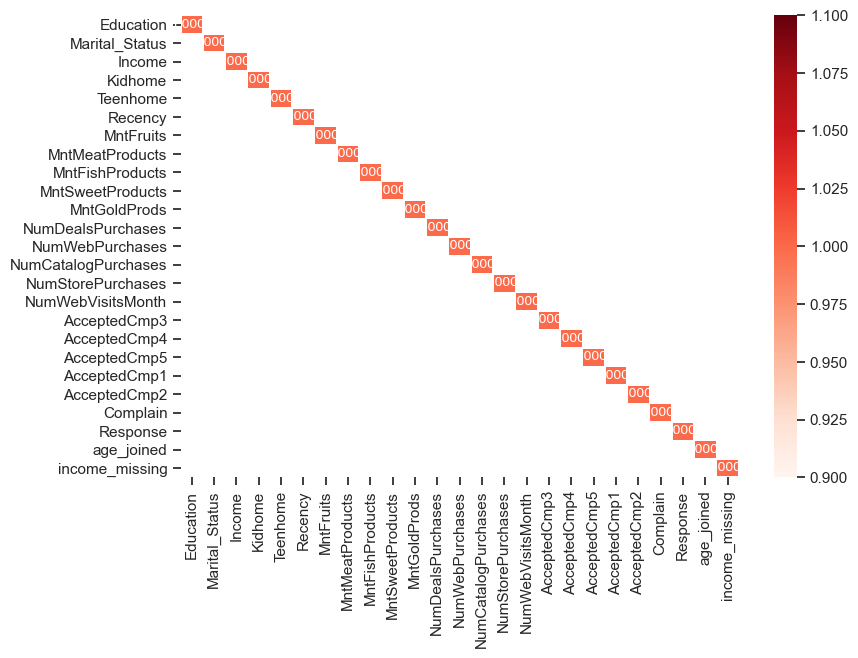

In [17]:
# examine the existence of collinearity using correlation matrix
corr = X_train_clean.corr()
sns.heatmap(data = corr[corr == 1], cmap='Reds', annot = True, fmt='.4f', linewidths=0.5, annot_kws={'size': 10})

In [18]:
# cleaning based on finding 1
# keep a copy of the unstardardised predictors for later use
X_train_without_standardised = X_train_clean.copy()
X_val_without_standardised = X_val_clean.copy()
X_test_without_standardised = X_test_clean.copy()

# standaridising the predictors
scaler = StandardScaler()
response = [target_y.name]
predictors = [x for x in list(X_train_clean.columns)]
train_set = pd.concat([X_train_clean, y_train], axis=1)

# mean and standard deviation of each predictors
mu = X_train_clean[predictors].mean()
sigma = X_train_clean[predictors].std()

# standardise the predictors in the training, validation and test sets (fit_transform on the training set, transform on the validation and test sets https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)
X_train_clean[predictors] = scaler.fit_transform(X_train_clean[predictors])
X_val_clean[predictors] = scaler.transform(X_val_clean[predictors])
X_test_clean[predictors] = scaler.transform(X_test_clean[predictors])

# glimpse of the standardised training set
X_train_clean.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined,income_missing
502,-2.085351,-0.984975,-1.047103,-0.823720,-0.922957,-1.456770,0.267906,-0.634696,-0.310969,0.835217,...,1.104745,-0.286926,-0.288348,-0.273896,-0.261927,-0.121953,-0.091895,-0.425874,-1.852099,-0.102851
424,-1.117008,-0.984975,1.488725,-0.823720,-0.922957,0.981437,0.421480,2.382895,0.327872,-0.647562,...,-1.356669,-0.286926,-0.288348,3.651027,-0.261927,-0.121953,-0.091895,-0.425874,2.304609,-0.102851
1467,-0.148664,-0.214102,1.150002,-0.823720,-0.922957,0.294618,0.139928,0.772066,0.692923,0.093827,...,-1.766904,-0.286926,-0.288348,3.651027,-0.261927,-0.121953,-0.091895,-0.425874,1.390133,-0.102851
1070,-1.117008,-0.214102,-0.729405,1.052896,-0.922957,1.015778,-0.653537,-0.660747,-0.639516,-0.623647,...,1.104745,-0.286926,-0.288348,-0.273896,-0.261927,-0.121953,-0.091895,-0.425874,-0.106282,-0.102851
1065,-0.148664,-0.984975,-1.320759,1.052896,0.906362,-1.010338,-0.551155,-0.708507,-0.621263,-0.575815,...,0.694509,-0.286926,-0.288348,-0.273896,-0.261927,-0.121953,-0.091895,-0.425874,0.558792,-0.102851


## EDA


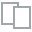
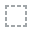
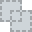
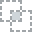
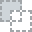
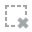
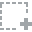
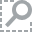
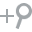
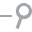
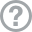
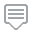
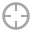
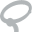
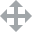
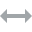
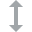
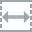
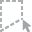
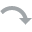
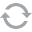
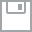
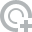
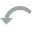
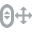
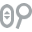
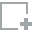
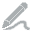
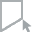
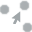
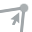
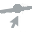

In [19]:
# inspect and visualise the response variable in the standardised training set
standardised_train_set = pd.concat([X_train_clean, y_train], axis=1)
plot(standardised_train_set, 'MntWines')

Findings:
1. The response has a large standard deviation (334.5343) relative to the mean (305.4787): factors to consider when discussing the coefficient sizes and prediction errors.

2. The skewness of the response is 1.118, which suggests that the distribution of the amount spent on wine products is right-skewed, indicating that there are more customers who spend less on wine products than those who spend more. 

3. The normal QQ plot suggests that the `MntWines` violates the normality assumption

In [20]:
# examining perfect positive correlation between predictors using correlation matrix
def perfect_collinearity(df):
    collinear_colns = []
    suspicious_colns = []
    corr = df.corr().abs()
    corr = corr.unstack()
    corr = corr.sort_values(ascending=False)
    for i in range(0, len(corr)):
        if corr[i] == 1.0000 and corr.index[i][0] != corr.index[i][1]:
            collinear_colns.append((corr.index[i][0], corr.index[i][1]))
        elif corr[i] > 0.5000 and corr.index[i][0] != corr.index[i][1]:
            suspicious_colns.append((corr.index[i][0], corr.index[i][1]))
    return collinear_colns, suspicious_colns

collinear_colns, suspicious_colns = perfect_collinearity(standardised_train_set)
print('Collinear columns: ', collinear_colns)
print('Suspicious columns: ', suspicious_colns)

Collinear columns:  []
Suspicious columns:  [('NumCatalogPurchases', 'MntMeatProducts'), ('MntMeatProducts', 'NumCatalogPurchases'), ('NumStorePurchases', 'MntWines'), ('MntWines', 'NumStorePurchases'), ('MntFishProducts', 'MntFruits'), ('MntFruits', 'MntFishProducts'), ('NumCatalogPurchases', 'MntWines'), ('MntWines', 'NumCatalogPurchases'), ('MntFishProducts', 'MntSweetProducts'), ('MntSweetProducts', 'MntFishProducts'), ('MntSweetProducts', 'MntFruits'), ('MntFruits', 'MntSweetProducts'), ('MntMeatProducts', 'MntFishProducts'), ('MntFishProducts', 'MntMeatProducts'), ('MntMeatProducts', 'NumWebVisitsMonth'), ('NumWebVisitsMonth', 'MntMeatProducts'), ('NumWebPurchases', 'MntWines'), ('MntWines', 'NumWebPurchases'), ('NumCatalogPurchases', 'Income'), ('Income', 'NumCatalogPurchases'), ('MntMeatProducts', 'MntFruits'), ('MntFruits', 'MntMeatProducts'), ('MntWines', 'MntMeatProducts'), ('MntMeatProducts', 'MntWines'), ('NumWebVisitsMonth', 'Income'), ('Income', 'NumWebVisitsMonth'), ('N

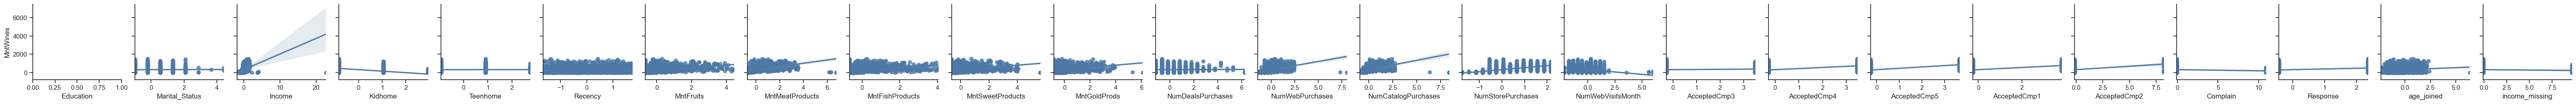

In [21]:
# bivariate relationship between the predictors and response using pairplot with regression line
sns.pairplot(standardised_train_set, x_vars=predictors, y_vars=response, kind='reg')

Finding:
`Income`, `MntMeatProducts`, `NumWebPurchases`, and `NumCatalogPurchases` seems to be some good predictors of `MntWines` from the pairplot.

In [22]:
# use VIF to double check if the suspicious predictors are indeed causing multicollinearity
# VIF > 5 indicates multicollinearity

vif_data = pd.DataFrame()
vif_data["predictors"] = predictors
vif_data["VIF"] = [variance_inflation_factor(X_train_clean.values, i) for i in range(len(predictors))]
vif_data.sort_values(by='VIF', ascending=False)
vif_data.round(4)

,predictors,VIF
0,Education,1.0207
1,Marital_Status,1.0367
2,Income,1.8058
3,Kidhome,1.8662
4,Teenhome,1.6351
5,Recency,1.0710
6,MntFruits,1.9497
7,MntMeatProducts,3.0147
8,MntFishProducts,2.2054
9,MntSweetProducts,1.9147


Findings:

Though through the correlation matrix, it is evident that some predictors like `MntMeatProducts` and `NumCatalogPurchases` are highly correlated that may lead to multicollinearity issues, the VIF values of the predictors are all below 5, which suggests that multicollinearity is not a problem in this dataset. 

Therefore, we will perform systematic feature selection to select the best subset of predictors that maximises the predictive accuracy of the model.

# Model Selection

## 1. Linear Model (Linear Regression)

### 1.1 Variable Selection using Forward Stepwise Selection and Hypothesis Testing

In [23]:
# Forward selection referencing qbus2810 tutorial code
def forward_selection(std_df, x_val, y_val, predictors, response, nominated=[]):
    x_train = std_df[predictors]
    y_train = std_df[response]
    remaining_p = set(x_train.columns)
    selected_p = nominated
    current_mae, best_new_mae = np.inf, np.inf

    # loop until no variable can be added
    while remaining_p:
        scores_with_candidates = []
        for candidate in list(remaining_p):
            selected_c = selected_p + [candidate]
            # add constant to the predictors
            x_train_intercept = sm.add_constant(x_train[selected_c], prepend=True)
            x_val_intercept = sm.add_constant(x_val[selected_c], prepend=True)
            # fit the model using the training set
            model = sm.OLS(y_train, x_train_intercept).fit()
            # check p-value
            p_value = model.pvalues[1]
            # if p-value > 0.05, skip the variable
            if p_value > 0.05:
                continue
            # input the validation set into the model trained using the training set to obtain the predicted values
            y_pred_hat = model.predict(x_val_intercept)
            # compare the predicted values with the actual values in the validation set to obtain the MAE
            mae = metrics.mean_absolute_error(y_val, y_pred_hat)
            scores_with_candidates.append((mae, candidate))
        # sort the MAE in ascending order
        scores_with_candidates.sort()
        # select the variable with the lowest MAE
        best_new_mae, best_candidate = scores_with_candidates[0]
        # if the MAE is lower than the current MAE, add the variable to the selected list
        if round(best_new_mae, 4) < round(current_mae, 4):
            # print(f"adding {best_candidate} decreases MAE from {current_mae} to {best_new_mae}")
            remaining_p.remove(best_candidate)
            selected_p.append(best_candidate)
            current_mae = best_new_mae
        else:
            remaining_p.remove(best_candidate)
    
    # return the selected predictors
    return selected_p, round(best_new_mae, 4)
                
best_predictors_linear_model, mae_var_selection_1 = forward_selection(standardised_train_set, X_val_clean, y_val, predictors, response, nominated=[])
model1 = sm.OLS(y_train, sm.add_constant(X_train_clean[best_predictors_linear_model], prepend=True)).fit()
print(mae_var_selection_1)
model1.summary()

113.5577


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MntWines   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     205.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:16:11   Log-Likelihood:                -9534.6
No. Observations:                1433   AIC:                         1.910e+04
Df Residuals:                    1417   BIC:                         1.919e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 305.4787      4.986     61.273      0.000     295.699     315.258
NumStorePurchases     107.8861      6.892     15.653      0.000      94.366     121.406
NumCatalogPurchases    82.2910      8.093     10.168      0.000      66.415      98.167
AcceptedCmp4           47.6466      5.485      8.686      0.000      36.887      58.407
NumWebPurchases        63.0161      6.258     10.070      0.000      50.740      75.292
AcceptedCmp5           65.3639      5.984     10.922      0.000      53.625      77.103
Income                 32.5176      6.682      4.866      0.000      19.409      45.626
NumWebVisitsMonth      41.8280      6.958      6.012      0.000      28.179      55.477
AcceptedCmp2           23.2371      5.311      4.375      0.000      12.818      33.656
Response                7.0241      5.598      1.255      0.210      -3.957      18.005
Teenhome                8.8935      5.882      1.512      0.131      -2.645      20.432
MntMeatProducts        29.9931      8.441      3.553      0.000      13.434      46.552
age_joined             13.2146      5.485      2.409      0.016       2.455      23.974
Marital_Status          1.2873      5.057      0.255      0.799      -8.633      11.208
income_missing         -3.7552      5.036     -0.746      0.456     -13.635       6.124
MntFruits              -0.7596      6.268     -0.121      0.904     -13.056      11.536
==============================================================================
Omnibus:                      204.674   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              996.341
Skew:                           0.576   Prob(JB):                    4.44e-217
Kurtosis:                       6.919   Cond. No.                         4.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2 Variable Selection using Automatic Forward Variable Selection

In [24]:
# automatic stepwise variable selection
linreg = LinearRegression()
sfs2 = SFS(linreg,
          k_features = (1, len(predictors)),
            forward = True,
            floating = False,
            scoring = 'neg_mean_absolute_error', # the higher the better since the score is obtained by negating MAE
            cv = 0)
# fit the model using the training set
sfs2.fit(X_train_clean, y_train)
selected_predictors2 = list(sfs2.k_feature_names_)

# fit the model using the selected predictors
X_train_selected2 = sm.add_constant(X_train_clean[selected_predictors2], prepend=True)
X_val_selected2 = sm.add_constant(X_val_clean[selected_predictors2], prepend=True)
model2 = sm.OLS(y_train, X_train_selected2).fit()

# test on the validation set
y_pred_hat2 = model2.predict(X_val_selected2)
mae_var_selection_2 = metrics.mean_absolute_error(y_val, y_pred_hat2)
print('MAE of the linear model that uses forward selection: ', round(mae_var_selection_2, 4))

model2.summary()

MAE of the linear model that uses forward selection:  113.2355


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MntWines   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     223.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:16:12   Log-Likelihood:                -9527.5
No. Observations:                1433   AIC:                         1.909e+04
Df Residuals:                    1418   BIC:                         1.916e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 305.4787      4.959     61.599      0.000     295.751     315.207
Education              -5.2754      4.984     -1.059      0.290     -15.052       4.501
Income                 38.2844      6.549      5.846      0.000      25.438      51.131
MntFishProducts        -1.5747      6.741     -0.234      0.815     -14.799      11.650
MntSweetProducts      -21.0217      6.627     -3.172      0.002     -34.021      -8.022
NumDealsPurchases     -22.8625      5.833     -3.920      0.000     -34.304     -11.421
NumWebPurchases        71.8962      6.275     11.458      0.000      59.587      84.205
NumCatalogPurchases   103.2543      7.186     14.368      0.000      89.157     117.351
NumStorePurchases     117.3851      6.861     17.108      0.000     103.925     130.845
NumWebVisitsMonth      43.7080      7.351      5.946      0.000      29.287      58.129
AcceptedCmp3            7.4590      5.165      1.444      0.149      -2.672      17.590
AcceptedCmp4           46.5296      5.540      8.399      0.000      35.662      57.397
AcceptedCmp5           60.8823      5.941     10.247      0.000      49.228      72.537
AcceptedCmp1           15.6620      5.741      2.728      0.006       4.400      26.924
AcceptedCmp2           18.9215      5.305      3.567      0.000       8.516      29.327
==============================================================================
Omnibus:                      222.980   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1171.169
Skew:                           0.615   Prob(JB):                    4.83e-255
Kurtosis:                       7.254   Cond. No.                         3.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.3 Variable Selection using Automatic Backward Variable Selection

In [25]:
# automatic stepwise variable selection
linreg = LinearRegression()
sfs3 = SFS(linreg,
          k_features = (1, len(predictors)),
            forward = False,
            floating = False,
            scoring = 'neg_mean_absolute_error', # the higher the better since the score is obtained by negating MAE
            cv = 0)
# fit the model using the training set
sfs3.fit(X_train_clean, y_train)
selected_predictors3 = list(sfs3.k_feature_names_)

# fit the model using the selected predictors
X_train_selected3 = sm.add_constant(X_train_clean[selected_predictors3], prepend=True)
X_val_selected3 = sm.add_constant(X_val_clean[selected_predictors3], prepend=True)
model3 = sm.OLS(y_train, X_train_selected3).fit()

# test on the validation set
y_pred_hat3 = model3.predict(X_val_selected3)
mae_var_selection_3 = metrics.mean_absolute_error(y_val, y_pred_hat3)
print('MAE of the linear model that uses backward selection: ', round(mae_var_selection_3, 4))

model3.summary()

MAE of the linear model that uses backward selection:  113.2443


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               MntWines   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     225.1
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:16:14   Log-Likelihood:                -9524.0
No. Observations:                1433   AIC:                         1.908e+04
Df Residuals:                    1418   BIC:                         1.916e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 305.4787      4.947     61.750      0.000     295.774     315.183
Education              -5.3359      4.960     -1.076      0.282     -15.066       4.394
Income                 36.5375      6.564      5.567      0.000      23.662      49.413
Teenhome               15.0103      5.664      2.650      0.008       3.899      26.122
MntSweetProducts      -19.0755      6.238     -3.058      0.002     -31.312      -6.839
NumDealsPurchases     -28.0939      6.131     -4.582      0.000     -40.121     -16.066
NumWebPurchases        69.8486      6.303     11.082      0.000      57.484      82.213
NumCatalogPurchases   105.9923      7.102     14.925      0.000      92.061     119.923
NumStorePurchases     116.1634      6.779     17.136      0.000     102.866     129.461
NumWebVisitsMonth      45.8049      7.361      6.222      0.000      31.365      60.245
AcceptedCmp3            7.1850      5.152      1.395      0.163      -2.921      17.291
AcceptedCmp4           45.7873      5.515      8.302      0.000      34.968      56.606
AcceptedCmp5           63.3256      5.959     10.628      0.000      51.637      75.014
AcceptedCmp1           16.0666      5.680      2.829      0.005       4.924      27.209
AcceptedCmp2           18.9434      5.291      3.580      0.000       8.564      29.323
==============================================================================
Omnibus:                      225.779   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1109.227
Skew:                           0.646   Prob(JB):                    1.36e-241
Kurtosis:                       7.112   Cond. No.                         3.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.4 Linear Model Selection

In [26]:
# choose the model with the lowest MAE on the validation set
def best_linear_model():
    best_model = None
    if mae_var_selection_1 < mae_var_selection_2 and mae_var_selection_1 < mae_var_selection_3:
        name = 'Manual forward selection'
        mae = mae_var_selection_1
        best_predictors = best_predictors_linear_model
        best_model = model1
    elif mae_var_selection_2 < mae_var_selection_1 and mae_var_selection_2 < mae_var_selection_3:
        name = 'Automatic forward selection'
        mae = mae_var_selection_2
        best_predictors = selected_predictors2
        best_model = model2
    else:
        name = 'Automatic backward selection'
        mae = mae_var_selection_3
        best_predictors = selected_predictors3
        best_model = model3
    return best_predictors, best_model, name, mae

best_set_of_predictors, best_model, name, mae = best_linear_model()

print(f'Best model based on lowest MAE on the validation set: {name}')
print(f'MAE on the validation set: {round(mae, 4)}')
print(f'Best set of {len(best_set_of_predictors)} predictors: {best_set_of_predictors}')
print('Best model: ', best_model.summary())

Best model based on lowest MAE on the validation set: Automatic forward selection
MAE on the validation set: 113.2355
Best set of 14 predictors: ['Education', 'Income', 'MntFishProducts', 'MntSweetProducts', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']
Best model:                              OLS Regression Results                            
Dep. Variable:               MntWines   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     223.5
Date:                Sat, 30 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:16:14   Log-Likelihood:                -9527.5
No. Observations:                1433   AIC:                         1.909e+04
Df Residuals:                    1418   B

### 1.5 Evaluate the Performance of the Final Linear Model on the Test Set

In [27]:
predictions_stepwise = best_model.predict(sm.add_constant(X_test_clean[best_set_of_predictors], prepend=True))
mae_stepwise = metrics.mean_absolute_error(y_test, predictions_stepwise)
print('MAE of the best model on predicting the test set: ', round(mae_stepwise, 4))

MAE of the best model on predicting the test set:  120.1147


In [28]:
results_linear_model = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'main predictors (secondary goal)'],
    # index=['Linear Regression obtained from Manual forward selection with hypothesis testing', 'Linear Regression using automatic forward selection', 'Linear Regression using automatic backward selection'],
    index=['Linear Regression using automatic forward selection', 'Linear Regression using automatic backward selection'],
    dtype='float64'
    )
# manual and backward mae on test sets
predictions_stepwise_manual = model1.predict(sm.add_constant(X_test_clean[best_predictors_linear_model], prepend=True))
mae_stepwise_manual = metrics.mean_absolute_error(y_test, predictions_stepwise_manual)
predictions_stepwise_backward = model3.predict(sm.add_constant(X_test_clean[selected_predictors3], prepend=True))
mae_stepwise_backward = metrics.mean_absolute_error(y_test, predictions_stepwise_backward)

# results_linear_model.iloc[0,0] = mae_var_selection_1
results_linear_model.iloc[0,0] = mae_var_selection_2
results_linear_model.iloc[1,0] = mae_var_selection_3

# results_linear_model.iloc[0,1] = mae_stepwise_manual
results_linear_model.iloc[0,1] = mae_stepwise
results_linear_model.iloc[1,1] = mae_stepwise_backward

# results_linear_model.iloc[0,2] = ', '.join(best_predictors_linear_model)
results_linear_model.iloc[0,2] = ', '.join(selected_predictors2)
results_linear_model.iloc[1,2] = ', '.join(selected_predictors3)

results_linear_model.round(4)

,MAE on validation set,MAE on test set,main predictors (secondary goal)
Linear Regression using automatic forward selection,113.2355,120.1147,"Education, Income, MntFishProducts, MntSweetPr..."
Linear Regression using automatic backward selection,113.2443,120.5487,"Education, Income, Teenhome, MntSweetProducts,..."


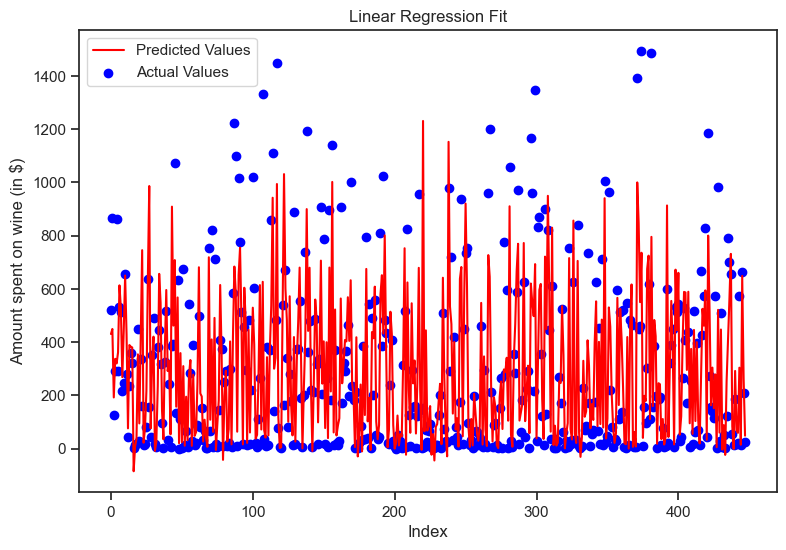

In [29]:
def plot_regression_fit_LR(y, title):
    # Predict the values with the model
    y_pred = predictions_stepwise
    
    # scatter plot of the actual amount spent on wine
    plt.scatter(np.arange(len(y)), y, color='blue', label='Actual Values')
    
    # line plot of the predicted amount spent on wine given the predictors
    plt.plot(np.arange(len(y)), y_pred, color='red', label='Predicted Values')
    
    # Add labels, title, legend, etc.
    plt.xlabel('Index')
    plt.ylabel('Amount spent on wine (in $)')
    plt.title(title)
    plt.legend()
    plt.show()

# plot the regression fit
plot_regression_fit_LR(y_test, 'Linear Regression Fit')

## 2. KNN Model

### 2.1 Hyperparameter Tuning for KNN Model (Find the best k)

In [30]:
# find the best k for knn
def knn_cv(df, neighbours, predictors, response):
    best_score = -np.inf
   
    for k in neighbours:
        ## data already standardised, so use euclidean distance
        knn = KNeighborsRegressor(n_neighbors = k, metric='euclidean')
        scores = cross_val_score(knn, df[predictors], df[response], cv=10, scoring = 'neg_mean_absolute_error')
        cv_score = np.mean(scores)
        if cv_score >= best_score: # since we are using negative MAE, the higher the better
            best_score = cv_score
            best_knn = knn
    knn = best_knn
    cv_mae = -best_score
    # print('Chosen K: {}'.format(knn.n_neighbors))
    return knn, cv_mae

### 2.2 Variable Selection

In [31]:
def knn_var_selection(df, predictor, response):
    result = pd.DataFrame(columns=['name', 'Chosen_K', 'CV_MAE'])
    best_mae = np.inf
    chosen_predictors = []
    best_knn = None

    while predictor:
        for p in predictor:
            curr_predictors = chosen_predictors + [p]
            knn, cv_mae = knn_cv(df, np.arange(1,11), curr_predictors, response) # here we use arange(1,11) to save time
            dic = {'name': curr_predictors,
                'Chosen_K': knn.n_neighbors,
                'CV_MAE': cv_mae.round(4)}
            
            new_row = pd.DataFrame([dic])
            result = pd.concat([result, new_row], ignore_index=True)
        result.sort_values(by='CV_MAE', ascending=True, inplace=True)
        curr_best_p, knn, curr_best_mae = result.iloc[0,0], result.iloc[0,1], result.iloc[0,2]
        # if the current best MAE is lower than the previous best MAE, update the best MAE and the chosen predictors
        if curr_best_mae < best_mae:
            best_knn = knn
            best_mae = curr_best_mae
            # append the current best predictor to the chosen predictors
            chosen_predictors = curr_best_p
            predictor.remove(chosen_predictors[-1])
        else:
            break
    return best_mae, chosen_predictors, best_knn

predictors_knn = predictors.copy()
best_mae, chosen_predictors_knn, best_knn = knn_var_selection(standardised_train_set, predictors_knn, response)
best_mae, chosen_predictors_knn, best_knn
print(f'Best MAE: {round(best_mae, 4)} with K = {best_knn} and predictors: {chosen_predictors_knn}')

Best MAE: 86.1351 with K = 4 and predictors: ['NumCatalogPurchases', 'NumWebPurchases', 'Income', 'NumWebVisitsMonth', 'AcceptedCmp5', 'NumStorePurchases', 'MntMeatProducts', 'MntFishProducts']


In [32]:
print(f'Best MAE: {round(best_mae, 4)} \nK = {best_knn} \nPredictors: {chosen_predictors_knn}\nNumber of predictors: {len(chosen_predictors_knn)}')

Best MAE: 86.1351 
K = 4 
Predictors: ['NumCatalogPurchases', 'NumWebPurchases', 'Income', 'NumWebVisitsMonth', 'AcceptedCmp5', 'NumStorePurchases', 'MntMeatProducts', 'MntFishProducts']
Number of predictors: 8


### 2.3 Final 4NN Model

In [33]:
# final model knn regression model
knn_final = KNeighborsRegressor(n_neighbors = best_knn, metric='euclidean')
knn_final.fit(X_train_clean[chosen_predictors_knn], y_train)
knn_final

KNeighborsRegressor(metric='euclidean', n_neighbors=4)

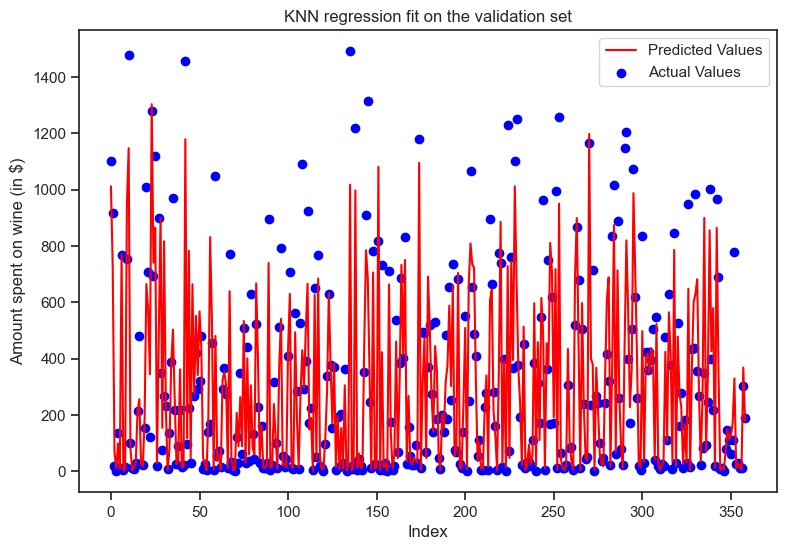

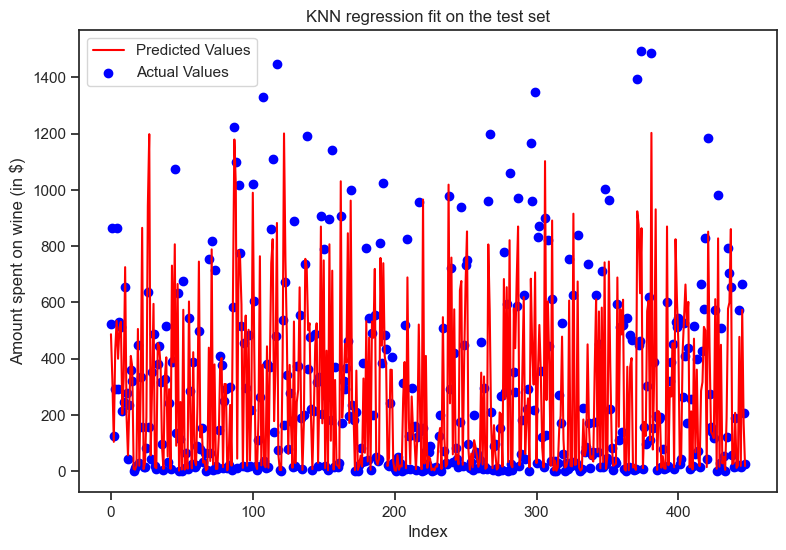

In [34]:
def plot_regression_fit_knn(model, X, y, title):
    
    # Predict the values with the model
    y_pred = model.predict(X[chosen_predictors_knn])
    
    # scatter plot of the actual amount spent on wine
    plt.scatter(np.arange(len(y)), y, color='blue', label='Actual Values')
    
    # line plot of the predicted amount spent on wine given the predictors
    plt.plot(np.arange(len(y)), y_pred, color='red', label='Predicted Values')
    
    # Add labels, title, legend, etc.
    plt.xlabel('Index')
    plt.ylabel('Amount spent on wine (in $)')
    plt.title(title)
    plt.legend()
    plt.show()

# assess the performance of the model on the validation set
plot_regression_fit_knn(knn_final, X_val_clean, y_val, 'KNN regression fit on the validation set')

# assess the performance of the model on the test set
plot_regression_fit_knn(knn_final, X_test_clean, y_test, 'KNN regression fit on the test set')


### 2.4 Evaluate the Performance of the Final KNN Model on the Validation and Test Set

In [35]:
# mae on the validation set
knn_final.fit(X_train_clean[chosen_predictors_knn], y_train)
y_pred_hat = knn_final.predict(X_val_clean[chosen_predictors_knn])
mae_knn_val = metrics.mean_absolute_error(y_val, y_pred_hat)
print('MAE of the best model on predicting the validation set: ', round(mae_knn_val, 4))

# mae on the test set
knn_final.fit(X_train_clean[chosen_predictors_knn], y_train)
y_pred_hat = knn_final.predict(X_test_clean[chosen_predictors_knn])
mae_knn_test = metrics.mean_absolute_error(y_test, y_pred_hat)
print('MAE of the best model on predicting the test set: ', round(mae_knn_test, 4))

MAE of the best model on predicting the validation set:  91.1692
MAE of the best model on predicting the test set:  87.9202


In [36]:
results_knn = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'main predictors (secondary goal)'],
    index=['KNN: {}NN Model'.format(best_knn)],
    dtype='float64'
    )

results_knn.iloc[0,0] = round(mae_knn_val, 4)
results_knn.iloc[0,1] = round(mae_knn_test, 4)
results_knn.iloc[0,2] = ', '.join(chosen_predictors_knn)

results_knn

,MAE on validation set,MAE on test set,main predictors (secondary goal)
KNN: 4NN Model,91.1692,87.9202,"NumCatalogPurchases, NumWebPurchases, Income, ..."


## 3. Random Forest Regression

### 3.1 Feature Importance

<AxesSubplot:xlabel='Predictors'>

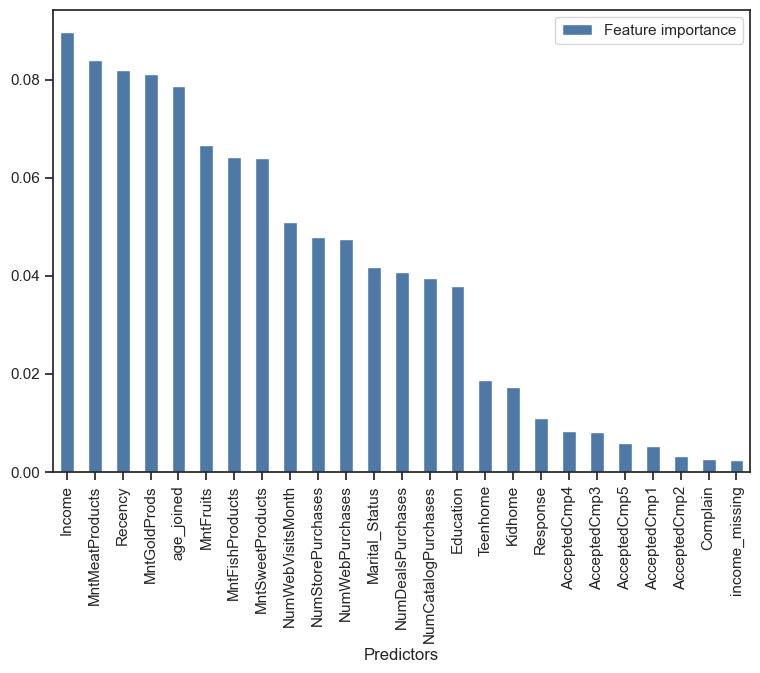

In [37]:
# rank the predictors based on their importance
random_forest_clf = RandomForestClassifier(random_state=1)
# fit the model using the training set
random_forest_clf.fit(X_train_clean, y_train)
# plot for feature importance
feature_imp = random_forest_clf.feature_importances_
feature_imp_df = pd.DataFrame({'Predictors': predictors, 'Feature importance': feature_imp})
feature_imp_df.sort_values(by='Feature importance', ascending=False, inplace=True)
feature_imp_df.plot.bar(x='Predictors', y='Feature importance', rot=90)

Finding:

- `Income`, `MntMeatProducts`, and `Recency` are the top three most important features, indicating they contribute significantly to the model's predictive power

### 3.2 Hyperparameter Tuning for Random Forest Regression (Find the best n_estimator and max_depth)
reference: https://www.datacamp.com/tutorial/random-forests-classifier-python

In [38]:
# use random search to find the best hyperparameters for random forest
param_grid = {'n_estimators': np.arange(10, 100, 10),
              'max_depth': randint(1, 20)}

rf_clf = RandomForestClassifier(random_state=1)
# use random search to find the best hyperparameters for random forest
rf_random_search = RandomizedSearchCV(rf_clf, param_grid, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)
rf_random_search.fit(X_train_clean, y_train)
best_rf = rf_random_search.best_params_
best_rf

{'max_depth': 18, 'n_estimators': 90}

### 3.3 Final Random Forest Regression Model

<AxesSubplot:xlabel='Predictors'>

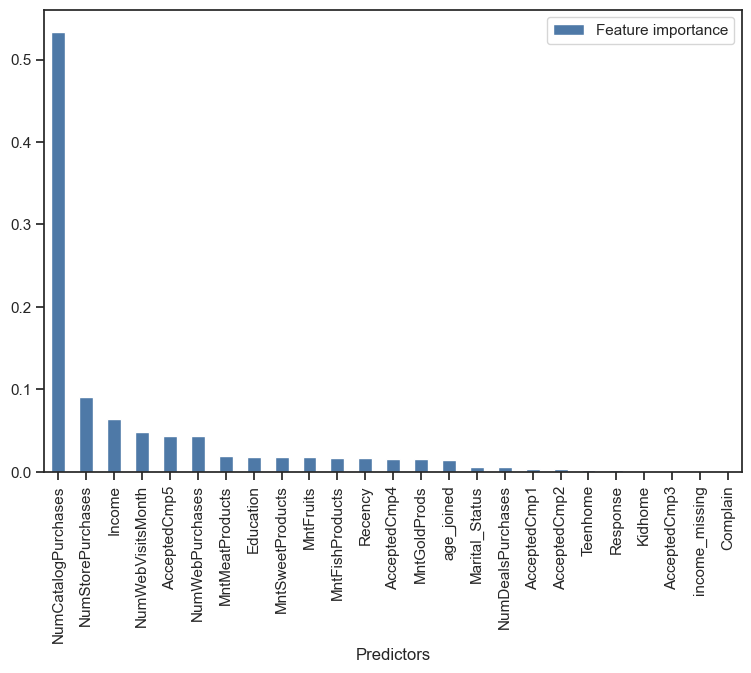

In [39]:
# build the random forest model using the best hyperparameters
rf_model = RandomForestRegressor(n_estimators=best_rf['n_estimators'], max_depth=best_rf['max_depth'], random_state=1)
# fit the model using the training set
rf_model.fit(X_train_clean, y_train)
rf_model_df = pd.DataFrame({'Predictors': predictors, 'Feature importance': rf_model.feature_importances_})
rf_model_df.sort_values(by='Feature importance', ascending=False, inplace=True)
rf_model_df.plot.bar(x='Predictors', y='Feature importance', rot=90)

### 3.4 Evaluate the Performance of the Final Random Forest Regression Model on the Validation and Test Set

In [40]:
results_rf = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'main predictors (secondary goal)'],
    index=['Random Forest Regression Model'],
    dtype='float64'
    )

y_pred_val = rf_model.predict(X_val_clean)
mae_rf_val = metrics.mean_absolute_error(y_val, y_pred_val)
y_pred_test = rf_model.predict(X_test_clean)
mae_rf_test = metrics.mean_absolute_error(y_test, y_pred_test)

results_rf.iloc[0,0] = round(mae_rf_val, 4)
results_rf.iloc[0,1] = round(mae_rf_test, 4)
results_rf.iloc[0,2] = rf_model_df.head(6)

results_rf

,MAE on validation set,MAE on test set,main predictors (secondary goal)
Random Forest Regression Model,93.8339,90.8465,"[NumCatalogPurchases, NumStorePurchases, Incom..."


# Model Evaluation Based on MAE

In [41]:
# combine results
results_multiple_p = pd.concat([results_linear_model, results_knn, results_rf])
results_multiple_p.round(4)

,MAE on validation set,MAE on test set,main predictors (secondary goal)
Linear Regression using automatic forward selection,113.2355,120.1147,"Education, Income, MntFishProducts, MntSweetPr..."
Linear Regression using automatic backward selection,113.2443,120.5487,"Education, Income, Teenhome, MntSweetProducts,..."
KNN: 4NN Model,91.1692,87.9202,"NumCatalogPurchases, NumWebPurchases, Income, ..."
Random Forest Regression Model,93.8339,90.8465,"[NumCatalogPurchases, NumStorePurchases, Incom..."


In [42]:
# best model
best_model = results_multiple_p['MAE on validation set'].idxmin()
print(f'Best model measured by MAE on the validation set: \n{best_model}, which has also produced the lowest MAE on the test set. (see below)\n')
print(f'Best model measured by MAE on the test set: \n{results_multiple_p["MAE on test set"].idxmin()}')


Best model measured by MAE on the validation set: 
KNN: 4NN Model, which has also produced the lowest MAE on the test set. (see below)

Best model measured by MAE on the test set: 
KNN: 4NN Model


## Application of the best model on a single sample

In [43]:
# use the best knn model to predict the money spent on wine products in the last 2 years for a given customer
knn_final = KNeighborsRegressor(n_neighbors = best_knn, metric='euclidean')
knn_final.fit(X_train_clean[chosen_predictors_knn], y_train)

# assume a customer with the following characteristics (since knn requires certain informations as described in the chosen_predictors_knn in order to predict)
new_customer_data = pd.DataFrame({
    'NumCatalogPurchases': [10],
    'NumWebPurchases': [5],
    'Income': [50000],
    'NumWebVisitsMonth': [3],
    'AcceptedCmp5': [0],
    'NumStorePurchases': [8],
    'MntMeatProducts': [200],
    'MntFishProducts': [100]
}, index=[0])

# predict the amount spent on wine products in the last 2 years
predict_amount_spent_wine = knn_final.predict(new_customer_data)

print(f'Predicted amount spent on wine products in the last 2 years: ${round(predict_amount_spent_wine[0], 4)}')

Predicted amount spent on wine products in the last 2 years: $42.25


# Additional Exercises

## 1. Best predictive model that uses a single predictor

### 1.1 Linear Model (SLR)

In [44]:
# linear model
def find_best_slr(df, predictors, response):
    best_mae = np.inf
    for p in predictors:
        formula = "{} ~ {}".format(response[0], p)
        model_slr = smf.ols(formula = formula, data = df)
        results = model_slr.fit()
        # check p-value
        if results.pvalues[1] > 0.05:
            continue
        # test the model on the validation set
        y_pred_hat = results.predict(X_val_clean[p])
        mae = metrics.mean_absolute_error(y_val, y_pred_hat)
        if mae < best_mae:
            best_mae_slr = mae
            best_model_slr = results
            best_predictor_slr = p
    return best_model_slr, best_predictor_slr, best_mae_slr
best_model_slr, best_predictor_slr, best_mae_slr = find_best_slr(standardised_train_set, predictors, response)

mae_val_slr = round(best_mae_slr, 4)
mae_test_slr = round(metrics.mean_absolute_error(y_test, best_model_slr.predict(X_test_clean[best_predictor_slr])), 4)
print('Best predictor: ', best_predictor_slr)
print('MAE on the validation set: ', mae_val_slr)
print('MAE on the test set: ', mae_test_slr)
print('Best model: ', best_model_slr.summary())

Best predictor:  age_joined
MAE on the validation set:  274.2544
MAE on the test set:  263.1235
Best model:                              OLS Regression Results                            
Dep. Variable:               MntWines   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     25.45
Date:                Sat, 30 Sep 2023   Prob (F-statistic):           5.12e-07
Time:                        23:18:22   Log-Likelihood:                -10350.
No. Observations:                1433   AIC:                         2.070e+04
Df Residuals:                    1431   BIC:                         2.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [45]:
# slr performance
results_slr = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'Best predictor'],
    index=['SLR'],
    dtype='float64'
    )

results_slr.iloc[0,0] = round(mae_val_slr, 4)
results_slr.iloc[0,1] = round(mae_test_slr, 4)
results_slr.iloc[0,2] = best_predictor_slr

results_slr

,MAE on validation set,MAE on test set,Best predictor
SLR,274.2544,263.1235,age_joined


### 1.2 KNN Model
note: Euclidean and Mahalanobis will produce the same results when there is only one predictor

In [46]:
def knn_one_predictor(predictor, response):
    best_mae = np.inf
    best_model = None
    best_predictor_knn = None

    for p in predictor:
        # fit the knn model using the training set
        knn = KNeighborsRegressor(n_neighbors = 1, metric='euclidean')
        knn.fit(X_train_clean[p].values.reshape(-1,1), y_train)
        # get the best model based on the MAE on the validation set
        y_pred_hat = knn.predict(X_val_clean[p].values.reshape(-1,1))
        mae = metrics.mean_absolute_error(y_val, y_pred_hat)
        if mae < best_mae:
            best_mae = mae
            best_model = knn
            best_predictor_knn = p
    return best_model, best_predictor_knn, round(best_mae, 4)

best_model_knn_1p, best_predictor_knn_1p, best_mae_val_knn_1p = knn_one_predictor(predictors, response)
print(f'The predictor in the 1NN model with the lowest validation MAE: {best_predictor_knn_1p}')

The predictor in the 1NN model with the lowest validation MAE: Income


In [47]:
# knn performance
results_knn_1p = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'Best predictor'],
    index=['1NN'],
    dtype='float64'
    )

results_knn_1p.iloc[0,0] = round(best_mae_val_knn_1p, 4)

y_pred_hat_test = best_model_knn_1p.predict(X_test_clean[best_predictor_knn_1p].values.reshape(-1,1))
mae_test_knn_1p = metrics.mean_absolute_error(y_test, y_pred_hat_test)

results_knn_1p.iloc[0,1] = round(mae_test_knn_1p, 4)
results_knn_1p.iloc[0,2] = best_predictor_knn_1p

results_knn_1p

,MAE on validation set,MAE on test set,Best predictor
1NN,175.3231,165.4821,Income


### 1.3 Random Forest Regression

In [48]:
# use random forest to find the best predictor
rf_model_1p = RandomForestRegressor(n_estimators=best_rf['n_estimators'], max_depth=best_rf['max_depth'], random_state=1)
rf_model_1p.fit(X_train_clean, y_train)

# predict on validation set
y_pred_val_rf_1p = rf_model_1p.predict(X_val_clean)
mae_val_rf_1p = metrics.mean_absolute_error(y_val, y_pred_val_rf_1p)

# predict on the test set
y_pred_test_rf_1p = rf_model_1p.predict(X_test_clean)
mae_test_rf_1p = metrics.mean_absolute_error(y_test, y_pred_test_rf_1p)

# best predictor in describing the MntWines
rf_model_1p_imp_p = pd.DataFrame({'Predictors': predictors, 'Feature importance': rf_model_1p.feature_importances_})
rf_model_1p_imp_p.sort_values(by='Feature importance', ascending=False, inplace=True)
best_predictor_rf_1p = rf_model_1p_imp_p.iloc[0]['Predictors']

print(f'Best predictor in the random forest model with the lowest validation MAE: {best_predictor_rf_1p}')

Best predictor in the random forest model with the lowest validation MAE: NumCatalogPurchases


In [49]:
# random forest regression model performance
results_rf_1p = pd.DataFrame(
    columns=['MAE on validation set', 'MAE on test set', 'Best predictor'],
    index=['Random Forest Regression Model with 1 predictor'],
    dtype='float64'
    )

results_rf_1p.iloc[0,0] = round(mae_val_rf_1p, 4)
results_rf_1p.iloc[0,1] = round(mae_test_rf_1p, 4)
results_rf_1p.iloc[0,2] = best_predictor_rf_1p

results_rf_1p

,MAE on validation set,MAE on test set,Best predictor
Random Forest Regression Model with 1 predictor,93.8339,90.8465,NumCatalogPurchases


### 1.4 Model Evaluation and Comparison

In [50]:
# concatenate the results
results_1p = pd.concat([results_slr, results_knn_1p, results_rf_1p])
results_1p

,MAE on validation set,MAE on test set,Best predictor
SLR,274.2544,263.1235,age_joined
1NN,175.3231,165.4821,Income
Random Forest Regression Model with 1 predictor,93.8339,90.8465,NumCatalogPurchases


Finding:

- The best predictive model that uses a single predictor is the Random Forest Regression model with `NumCatalogPurchases` in describing the amount spent on wine products in the last two years for a given customer, with a MAE on both the validation and test set being the lowest, at 93.7351 and 91.9402 respectively.

## 2. Adjustment to Models Given Asymmetric Error 

### 2.1 Apply Penalty to the MAE Metrics

In [51]:
def custom_asymmetric_mae(y_true, y_pred):
    err = y_true - y_pred
    # introduce a parameter alpha to control the penalty, the higher the alpha, the higher the penalty
    alpha = 0.7
    # overprediction is when err < 0 as y_pred > y_true , underprediction is when err > 0
    loss = np.where(err < 0, alpha * metrics.mean_absolute_error(y_true, y_pred), (1 - alpha) * metrics.mean_absolute_error(y_true, y_pred))
    return np.mean(loss)

Due to running time issue, the code implementation is described below:

Essentially we are changing the scorer system from 'neg_mean_absolute_error' to the customised scoring system as specified in the function above, namely the `custom_asymmetric_mae` for the models used in Section 1:

Here is a sample implementation:

```python
updated_scorer = make_scorer(custom_asymmetric_mae(y_val, <chosen_model>.predict(X_val_clean), greater_is_better=False))
```

- Here, `<chosen_model>` takes in the model subject to evaluation
- `X_val_clean` and `y_val` is just one of the pair that we can test, we can also evaluate the train set and the test set


## 3. Fairness Analysis
reference:  https://www.kaggle.com/code/touatousmane/demographic-group-bias-in-brain-stroke-dataset

### 3.1 Determine the Protected Groups (Sensitive Attributes)

In [52]:
# combine the cleaned training, validation and test sets
iFood_fairness_analysis_X = pd.concat([X_train_without_standardised, X_val_without_standardised, X_test_without_standardised])
iFood_fairness_analysis_Y = pd.concat([y_train, y_val, y_test])
iFood_fairness_analysis = pd.concat([iFood_fairness_analysis_X, iFood_fairness_analysis_Y], axis=1)
iFood_fairness_analysis.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined,income_missing,MntWines
502,1,1,24279.0,0,0,6,36,21,20,62,...,0,0,0,0,0,0,0,22,0,16
424,2,1,93027.0,0,0,77,42,716,55,0,...,0,0,1,0,0,0,0,72,0,1285
1467,3,2,83844.0,0,0,57,31,345,75,31,...,0,0,1,0,0,0,0,61,0,901
1070,2,2,32892.0,1,0,78,0,15,2,1,...,0,0,0,0,0,0,0,43,0,26
1065,3,1,16860.0,1,1,19,4,4,3,3,...,0,0,0,0,0,0,0,51,0,10


In [53]:
# protected group 1: less educated customers
# binarise less educated customers, 0 for less educated, 1 for more educated
iFood_fairness_analysis['is_educated'] = np.where(iFood_fairness_analysis['Education'] == dummy_var_dict['Basic'], 0, 1)
iFood_fairness_analysis.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined,income_missing,MntWines,is_educated
502,1,1,24279.0,0,0,6,36,21,20,62,...,0,0,0,0,0,0,22,0,16,1
424,2,1,93027.0,0,0,77,42,716,55,0,...,0,1,0,0,0,0,72,0,1285,1
1467,3,2,83844.0,0,0,57,31,345,75,31,...,0,1,0,0,0,0,61,0,901,1
1070,2,2,32892.0,1,0,78,0,15,2,1,...,0,0,0,0,0,0,43,0,26,1
1065,3,1,16860.0,1,1,19,4,4,3,3,...,0,0,0,0,0,0,51,0,10,1


In [54]:
# protected group 2: widow with children
# binarise widow with children, 1 for widow with children, 0 for others
iFood_fairness_analysis['is_widow_with_children'] = np.where((iFood_fairness_analysis['Marital_Status'] == dummy_var_dict['Widow']) & 
                                                    ((iFood_fairness_analysis['Kidhome'] > 0) | (iFood_fairness_analysis['Teenhome'] > 0)), 1, 0)
iFood_fairness_analysis

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined,income_missing,MntWines,is_educated,is_widow_with_children
502,1,1,24279.0,0,0,6,36,21,20,62,...,0,0,0,0,0,22,0,16,1,0
424,2,1,93027.0,0,0,77,42,716,55,0,...,1,0,0,0,0,72,0,1285,1,0
1467,3,2,83844.0,0,0,57,31,345,75,31,...,1,0,0,0,0,61,0,901,1,0
1070,2,2,32892.0,1,0,78,0,15,2,1,...,0,0,0,0,0,43,0,26,1,0
1065,3,1,16860.0,1,1,19,4,4,3,3,...,0,0,0,0,0,51,0,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,3,4,79734.0,0,0,72,8,232,23,62,...,0,1,0,0,0,45,0,572,1,0
192,4,2,36640.0,1,0,99,6,8,7,4,...,0,0,0,1,0,113,0,15,1,0
1878,2,3,69702.0,0,1,8,9,240,50,19,...,0,0,0,0,0,62,0,664,1,0
2035,1,3,60905.0,0,1,27,17,76,36,17,...,0,0,0,0,0,63,0,208,1,0


In [55]:
# binarise the response variable to 0 and 1 for the fairness analysis
# query negative price in mntwines
median_MntWines = iFood_fairness_analysis['MntWines'].median()
print(f'we take the median value of MntWines as the threshold: {median_MntWines}')
iFood_fairness_analysis['Spend_more_on_wine'] = np.where(iFood_fairness_analysis['MntWines'] > median_MntWines, 1, 0)
iFood_fairness_analysis.head()

we take the median value of MntWines as the threshold: 173.5


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,age_joined,income_missing,MntWines,is_educated,is_widow_with_children,Spend_more_on_wine
502,1,1,24279.0,0,0,6,36,21,20,62,...,0,0,0,0,22,0,16,1,0,0
424,2,1,93027.0,0,0,77,42,716,55,0,...,0,0,0,0,72,0,1285,1,0,1
1467,3,2,83844.0,0,0,57,31,345,75,31,...,0,0,0,0,61,0,901,1,0,1
1070,2,2,32892.0,1,0,78,0,15,2,1,...,0,0,0,0,43,0,26,1,0,0
1065,3,1,16860.0,1,1,19,4,4,3,3,...,0,0,0,0,51,0,10,1,0,0


### 3.2 Fairness Analysis on the Best Model
Mechanism
1. Statistical parity 
2. Disparate impact


Indications of no bias:
- SP: 0.0 (no risk difference)
- DI: 1.0 (perfect risk ratio)

Reference: https://www.kaggle.com/code/touatousmane/demographic-group-bias-in-brain-stroke-dataset


In [56]:
# Best Model: 4NN (from Model Selection Section)
knn_final = KNeighborsRegressor(n_neighbors = 4, metric='euclidean')
knn_final.fit(X_train_clean[chosen_predictors_knn], y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=4)

In [57]:
# standardise the knn chosen predictors
iFood_fairness_analysis[chosen_predictors_knn] = scaler.fit_transform(iFood_fairness_analysis[chosen_predictors_knn])

# predict the amount spent on wine products in the last 2 years
predict_amount_spent_wine = knn_final.predict(iFood_fairness_analysis[chosen_predictors_knn])

# binaries the predicted amount spent on wine products in the last 2 years
iFood_fairness_analysis['Predicted_Spend_more_on_wine'] = np.where(predict_amount_spent_wine > median_MntWines, 1, 0)
iFood_fairness_analysis.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Response,age_joined,income_missing,MntWines,is_educated,is_widow_with_children,Spend_more_on_wine,Predicted_Spend_more_on_wine
502,1,1,-1.116896,0,0,6,36,-0.646755,-0.320880,62,...,0,0,0,22,0,16,1,0,0,0
424,2,1,1.629453,0,0,77,42,2.433031,0.319948,0,...,0,0,0,72,0,1285,1,0,1,1
1467,3,2,1.262610,0,0,57,31,0.789001,0.686136,31,...,0,0,0,61,0,901,1,0,1,1
1070,2,2,-0.772823,1,0,78,0,-0.673343,-0.650449,1,...,0,0,0,43,0,26,1,0,0,0
1065,3,1,-1.413271,1,1,19,4,-0.722088,-0.632140,3,...,0,0,0,51,0,10,1,0,0,0


In [58]:
# store the 2 protected groups and the predicted response in a new dataframe
temp_df = iFood_fairness_analysis[['is_educated', 'is_widow_with_children', 'Spend_more_on_wine', 'Predicted_Spend_more_on_wine']]

# fairness analysis on the original dataset
# the portion of less educated customers who spend more on wine among all less educated customers
less_educated_spend_more_org = (iFood_fairness_analysis[(iFood_fairness_analysis['is_educated'] == 0) & (iFood_fairness_analysis['Spend_more_on_wine'] == 1)].shape[0]) / (iFood_fairness_analysis[iFood_fairness_analysis['is_educated'] == 0].shape[0])
print(f'Original Dataset: Less educated customers who spend more on wine among all less educated customers: {round(less_educated_spend_more_org, 4)}')

# the portion of more educated customers who spend more on wine among all more educated customers
more_educated_spend_more_org = (iFood_fairness_analysis[(iFood_fairness_analysis['is_educated'] == 1) & (iFood_fairness_analysis['Spend_more_on_wine'] == 1)].shape[0]) / (iFood_fairness_analysis[iFood_fairness_analysis['is_educated'] == 1].shape[0])
print(f'Original Dataset: More educated customers who spend more on wine among all more educated customers: {round(more_educated_spend_more_org, 4)}')

# fairness analysis on the best model: 4NN
# the portion of less educated customers who spend more on wine among all less educated customers
less_educated_spend_more_knn = (temp_df[(temp_df['is_educated'] == 0) & (temp_df['Predicted_Spend_more_on_wine'] == 1)].shape[0]) / (temp_df[temp_df['is_educated'] == 0].shape[0])
print(f'Best Model: Less educated customers who spend more on wine among all less educated customers: {round(less_educated_spend_more_knn, 4)}')

# the portion of more educated customers who spend more on wine among all more educated customers
more_educated_spend_more_knn = (temp_df[(temp_df['is_educated'] == 1) & (temp_df['Predicted_Spend_more_on_wine'] == 1)].shape[0]) / (temp_df[temp_df['is_educated'] == 1].shape[0])
print(f'Best Model: More educated customers who spend more on wine among all more educated customers: {round(more_educated_spend_more_knn, 4)}')

Original Dataset: Less educated customers who spend more on wine among all less educated customers: 0.4843
Original Dataset: More educated customers who spend more on wine among all more educated customers: 0.502
Best Model: Less educated customers who spend more on wine among all less educated customers: 0.5039
Best Model: More educated customers who spend more on wine among all more educated customers: 0.5282


In [59]:
# Statistical demographic parity
sdp_original_dataset = abs(less_educated_spend_more_org - more_educated_spend_more_org)
print(f'Original Dataset: Statistical demographic parity: {round(sdp_original_dataset, 4)}')

sdp_best_model = abs(less_educated_spend_more_knn - more_educated_spend_more_knn)
print(f'Best Model: Statistical demographic parity: {round(sdp_best_model, 4)}')

Original Dataset: Statistical demographic parity: 0.0178
Best Model: Statistical demographic parity: 0.0243


In [60]:
# Disparate impact
di_original_dataset = less_educated_spend_more_org / more_educated_spend_more_org
print(f'Original Dataset: Disparate impact: {round(di_original_dataset, 4)}')

di_best_model = less_educated_spend_more_knn / more_educated_spend_more_knn
print(f'Best Model: Disparate impact: {round(di_best_model, 4)}')

Original Dataset: Disparate impact: 0.9646
Best Model: Disparate impact: 0.9541


In [61]:
# do the same for widow with children
# fairness analysis on the original dataset
# the porportion of widow with children who spend more on wine among all widow with children
widow_with_children_spend_more_org = (iFood_fairness_analysis[(iFood_fairness_analysis['is_widow_with_children'] == 1) & (iFood_fairness_analysis['Spend_more_on_wine'] == 1)].shape[0]) / (iFood_fairness_analysis[iFood_fairness_analysis['is_widow_with_children'] == 1].shape[0])
print(f'Original Dataset: Widow with children who spend more on wine among all widow with children: {round(widow_with_children_spend_more_org, 4)}')

# the portion of others who spend more on wine among all others who is not widow with children
others_spend_more_org = (iFood_fairness_analysis[(iFood_fairness_analysis['is_widow_with_children'] == 0) & (iFood_fairness_analysis['Spend_more_on_wine'] == 1)].shape[0]) / (iFood_fairness_analysis[iFood_fairness_analysis['is_widow_with_children'] == 0].shape[0])
print(f'Original Dataset: Others who spend more on wine among all others who is not widow with children: {round(others_spend_more_org, 4)}')

# fairness analysis on the best model: 4NN
# the porportion of widow with children who spend more on wine among all widow with children
widow_with_children_spend_more_knn = (temp_df[(temp_df['is_widow_with_children'] == 1) & (temp_df['Predicted_Spend_more_on_wine'] == 1)].shape[0]) / (temp_df[temp_df['is_widow_with_children'] == 1].shape[0])
print(f'Best Model: Widow with children who spend more on wine among all widow with children: {round(widow_with_children_spend_more_knn, 4)}')

# the portion of others who spend more on wine among all others who is not widow with children
others_spend_more_knn = (temp_df[(temp_df['is_widow_with_children'] == 0) & (temp_df['Predicted_Spend_more_on_wine'] == 1)].shape[0]) / (temp_df[temp_df['is_widow_with_children'] == 0].shape[0])
print(f'Best Model: Others who spend more on wine among all others who is not widow with children: {round(others_spend_more_knn, 4)}')

Original Dataset: Widow with children who spend more on wine among all widow with children: 0.54
Original Dataset: Others who spend more on wine among all others who is not widow with children: 0.4991
Best Model: Widow with children who spend more on wine among all widow with children: 0.56
Best Model: Others who spend more on wine among all others who is not widow with children: 0.5247


In [62]:
# Statistical demographic parity
sdp_original_dataset = abs(widow_with_children_spend_more_org - others_spend_more_org)
print(f'Original Dataset: Statistical demographic parity: {round(sdp_original_dataset, 4)}')

sdp_best_model = abs(widow_with_children_spend_more_knn - others_spend_more_knn)
print(f'Best Model: Statistical demographic parity: {round(sdp_best_model, 4)}')

Original Dataset: Statistical demographic parity: 0.0409
Best Model: Statistical demographic parity: 0.0353


In [63]:
# Disparate impact
di_original_dataset = others_spend_more_org / widow_with_children_spend_more_org
print(f'Original Dataset: Disparate impact: {round(di_original_dataset, 4)}')

di_best_model = others_spend_more_knn / widow_with_children_spend_more_knn
print(f'Best Model: Disparate impact: {round(di_best_model, 4)}')

Original Dataset: Disparate impact: 0.9242
Best Model: Disparate impact: 0.9369


Finding:
no systematic bias in the best model in terms of the widowed and other marital status groups as SDP and DI almost 0.0 and 1.0 respectively.